In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from dynamics_env.dynamics_rocket import Dynamics

In [2]:
destination_type = 'radius'
Myr_to_s = 86400 * 365
orbit_duration = 0.01 * Myr_to_s
orbit_timesteps = 1000
device = 'cpu'
seed = 0
rocket_mass = 433100
start = None
destination_type = 'radius'
destination_params = None
v_e = 3500
fuel_frac = 0.9
dry_mass = rocket_mass * (1 - fuel_frac)
capture_radius = 6371e2
thrust_coeff = 1
earth_orbital_speed = 2.977e4 # m/s

In [3]:
def make_env(seed):
    def thunk():
        env = Dynamics(hyperparameters={
            'planetary_model_list':['point_source', 'point_source', 'point_source'],
            'planetary_model_kwargs_list':[{'M':2e30, 'period':1e10, 'orbit_radius':0, 'phase':0}, # sun
                                            {'M':1.898e27, 'period':11.86, 'orbit_radius':7.7866e11, 'phase':0.785}, # jupiter
                                            {'M':5.972e24, 'period':1, 'orbit_radius':1.496e11, 'phase':3.945}], # earth
            'seed':seed,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk
    
env = make_env(seed=seed)()

In [ ]:
if start == None:
    leo_distance = 6371e3 + 300e3 # 300e3 m
    leo_speed = 7.7e3 # 7.7e3 m/s
    launch_theta = np.random.rand() * 2 * np.pi * 0
    earth_phase, earth_orbit_radius = env.planetary_models[-1].phase, env.planetary_models[-1].orbit_radius
    launch_position = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_distance + np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius
    launch_velocity = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_speed + env.planetary_models[-1].get_velocity(0, earth_orbital_speed)
    launch_mass = np.array([rocket_mass])
    init_params = np.concat([launch_position, launch_velocity, launch_mass])
else: init_params = np.array(start)
if destination_type == 'radius':
    if destination_params == None:
        destination_radius = 35768e3 # geocentric orbit radius
        start_center = np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius
        start_radius = 6371e3 + 300e3
    else:
        destination_radius = destination_params[0]
        start_center = destination_params[1]
        start_radius = destination_params[2]
elif destination_type == 'destination_planet':
    if destination_params == None:
        destination_planet_index = len(env.planetary_models)-1
        destination_planet_radius = 6051.8e3 # m (venus)
    else:
        destination_planet_index = destination_params[0]
        destination_planet_radius = destination_params[1]
    start_planet_distance = np.linalg.norm(init_params[:2] - env.planetary_models[destination_planet_index].get_position())
elif destination_type == 'destination':
    if destination_params == None:
        destination_distance = 3 * 1.496e11 # 3au in m
        destination_theta = np.random.rand() * 2 * np.pi # in rad
        destination_radius = 6371e3 # earth radius in m
    else:
        destination_distance = destination_params[0]
        destination_theta = destination_params[1]
        destination_radius = destination_params[2]
    start_destination_distance = np.linalg.norm(init_params[:2] - np.linalg.norm(np.array([np.cos(destination_theta), np.sin(destination_theta)]) * destination_distance))
    destination_coords = np.array([np.cos(destination_theta), np.sin(destination_theta)]) * destination_distance + np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius

In [ ]:
def event_dest_reached(t, y):
    pos = y[:2]
    if destination_type == 'radius':
        current_radius = np.linalg.norm(pos - start_center)
        completion = 0 if current_radius >= destination_radius else 1
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position()
        completion = 0 if np.linalg.norm(pos - planet_position) < destination_planet_radius else 1
    elif destination_type == 'destination':
        completion = 0 if np.linalg.norm(pos - destination_coords) < destination_radius else 1
    return completion
event_dest_reached.terminal = True
def rocket_captured(t, y):
    pos = y[:2]
    min_dist = np.inf
    for model in env.planetary_models:
        dist = np.linalg.norm(pos - model.get_position(t))
        min_dist = min(min_dist, dist)
    return min_dist - capture_radius
rocket_captured.terminal = True
# rocket_captured.direction = -1

rewards = np.zeros((orbit_timesteps,))
def rocket_function(t, y):
    # state packaging
    episode_step = int(t//(orbit_duration/orbit_timesteps))
    pos = y[:2]
    vel = y[2:4]
    mass = y[4:]
    a_gravity = env.get_acceleration(np.concat([pos, np.array([t])]))
    # action sampling
    action = env._process_actions(thrust_coeff * np.array([np.cos(0), np.sin(0)]))
    reward, done = reward_function(pos, mass, 0 if t == 0 else rewards[episode_step-1])
    # rocket science
    rewards[episode_step] = reward.item()
    thrust = action # in N (kg m/s^2)
    mdot = np.linalg.norm(thrust, axis=-1) / v_e # in m/s^2
    delta_m = mdot * orbit_duration / orbit_timesteps
    if (mass - delta_m) < dry_mass:
        a_thrust = np.zeros_like(thrust)
        mdot = 0
    else:
        a_thrust = thrust / mass

    # derivatives for integrator
    dydt = np.zeros_like(y)
    dydt[:2] = vel
    dydt[2:4] = a_gravity + a_thrust
    dydt[4] = mdot
    return dydt

def reward_function(pos, mass, previous_reward):
    if destination_type == 'radius':
        current_radius = np.linalg.norm(pos - start_center)
        consistent_reward = (current_radius - start_radius) / destination_radius + (1 - mass / rocket_mass)
        completion_reward = 10 if current_radius >= destination_radius else 0
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position()
        consistent_reward = (np.linalg.norm(planet_position - pos) - start_planet_distance) / start_planet_distance + (1 - mass / rocket_mass)
        completion_reward = 10 if np.linalg.norm(pos - planet_position) < destination_planet_radius else 0
    elif destination_type == 'destination':
        consistent_reward = (np.linalg.norm(destination_coords - pos) - start_destination_distance) / start_destination_distance + (1 - mass / rocket_mass)
        completion_reward = 10 if np.linalg.norm(pos - destination_coords) < destination_radius else 0
    return consistent_reward + completion_reward - previous_reward, completion_reward > 0

In [6]:
orbit = solve_ivp(rocket_function, t_span=(0, orbit_duration), y0=init_params, t_eval=np.linspace(0, orbit_duration, orbit_timesteps), events=[rocket_captured, event_dest_reached])
integrated_timesteps = len(orbit.y[0])

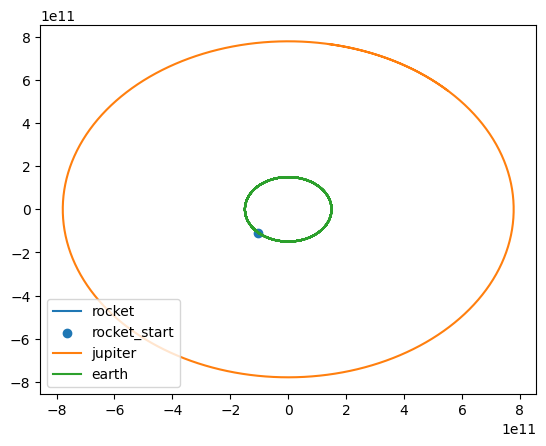

In [7]:
plot, axes = plt.subplots(1,1)
axes.plot(orbit.y[0], orbit.y[1], label='rocket')
axes.scatter(orbit.y[0,0], orbit.y[1,0], label='rocket_start')
jupiter_orbit = env.planetary_models[1].get_position(t=np.linspace(0, 13 * Myr_to_s, orbit_timesteps))
axes.plot(jupiter_orbit[0], jupiter_orbit[1], label='jupiter')
earth_orbit = env.planetary_models[2].get_position(t=np.linspace(0, 13 * Myr_to_s, orbit_timesteps))
axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
axes.legend()

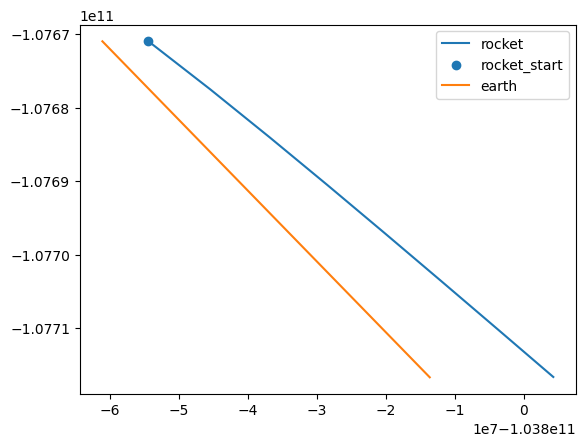

In [8]:
plot, axes = plt.subplots(1,1)
axes.plot(orbit.y[0], orbit.y[1], label='rocket')
axes.scatter(orbit.y[0,0], orbit.y[1,0], label='rocket_start')
earth_orbit = env.planetary_models[2].get_position(t=np.linspace(0, orbit_duration, orbit_timesteps)[:integrated_timesteps])
axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
axes.legend()

21.077064156266662


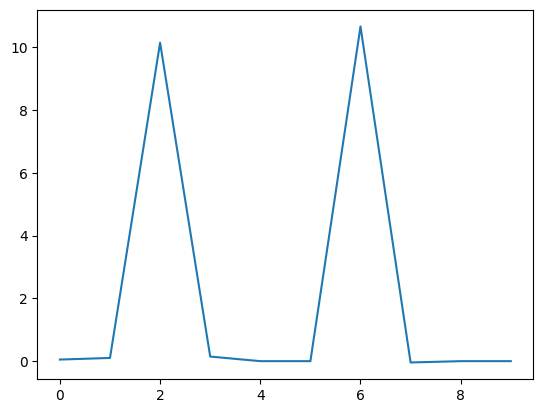

In [9]:
plt.plot(rewards[:10])
print(rewards.sum())

In [10]:
orbit

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  3.157e+02  6.314e+02  9.470e+02  1.263e+03
             1.578e+03  1.894e+03  2.210e+03]
        y: [[-1.039e+11 -1.038e+11 ... -1.038e+11 -1.038e+11]
            [-1.077e+11 -1.077e+11 ... -1.077e+11 -1.077e+11]
            ...
            [-2.067e+04 -2.067e+04 ... -2.067e+04 -2.067e+04]
            [ 4.331e+05  5.216e+05 ...  9.640e+05  1.052e+06]]
      sol: None
 t_events: [array([], dtype=float64), array([ 2.264e+03])]
 y_events: [array([], dtype=float64), array([[-1.038e+11, -1.077e+11,  2.559e+04, -2.067e+04,
                    1.068e+06]])]
     nfev: 32
     njev: 0
      nlu: 0